# Feature Selection by Filtering Methods

## Initialisation

In [ ]:
import os

import numpy as np
import pandas as pd

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path)
print(f'Project path set to: {os.getcwd()}')

In [ ]:
# Bring in CCLE data
from PathLoader import PathLoader
from DataLink import DataLink
path_loader = PathLoader('data_config.env', 'current_user.env')
data_link = DataLink(path_loader, 'data_codes.csv')

In [ ]:
# load in original ccle data
loading_code = 'generic-gdsc-1-FGFR_0939-LN_IC50-fgfr4_ccle_dynamic_features-true-Row'
# generic-gdsc-{number}-{drug_name}-{target_label}-{dataset_name}-{replace_index}-{row_index}
feature_data, label_data = data_link.get_data_using_code(loading_code)

In [ ]:
from toolkit import *

## Analysis Chain

In [ ]:
folder_name = "FeatureSelectionFGFR4"
exp_id = "range1000"
fixed_random_seed = 42 # -1 for no seed
save_figure = True
save_data = True
show_figure = True  

feature_size = feature_data.shape[1]
key_args = {'random_state': fixed_random_seed}

if not os.path.exists(f'{path_loader.get_data_path()}data/results/{folder_name}'):
    os.makedirs(f'{path_loader.get_data_path()}data/results/{folder_name}')

file_save_path = f'{path_loader.get_data_path()}data/results/{folder_name}/'

In [ ]:
def build_dataframe(selected_indices, scores, feature_data): 
    # if selected_indices are not indices but labels, skip the label conversion step 
    if not isinstance(selected_indices[0], int) and not isinstance(selected_indices[0], np.int64):
        labels = selected_indices
    else:
        labels = feature_data.columns[selected_indices]
    df = pd.DataFrame({'Selected': selected_indices, 'Scores': scores}, index=labels)
    sorted_df = df.sort_values(by='Scores', ascending=False)
    return sorted_df

In [ ]:
rf_selected, rf_score = rf_select(feature_data, label_data, feature_size, **key_args)
rf_select_df = build_dataframe(rf_selected, rf_score, feature_data)

In [ ]:
rf_select_df 

In [ ]:
relieff_selected, relieff_score = relieff_select(feature_data, label_data, feature_size)

In [ ]:
relieff_select_df = build_dataframe(relieff_selected, relieff_score, feature_data)
relieff_select_df

In [ ]:
f_selected, f_score = f_regression_select(feature_data, label_data, feature_size)
f_df = build_dataframe(f_selected, f_score, feature_data)
f_df

In [ ]:
pearson_kwargs = {'return_all': True}
pearson_selected, pearson_score, pearson_pvals = pearson_corr_select(feature_data, label_data, feature_size, **pearson_kwargs)
pearson_df = build_dataframe(pearson_selected, pearson_score, feature_data)
pearson_df

In [ ]:
mutual_selected, mutual_score = mutual_information_select(feature_data, label_data, feature_size)
mutual_df = build_dataframe(mutual_selected, mutual_score, feature_data)
mutual_df

there are two options to ensemble the results of multiple different feature selection results 
1. To propose a universal k-cutoff rank number for all feature selection methods and then union the features 
    e.g. Gather FS Method 1's top 100 features and Gather FS Method 2's top 100 features and union them 
2. To ensemble the rank value of each feature from each method first, and then limit the number of features either using a k-cutoff rank number, or a k-cutoff threshold for the ensemble score. 

## Universal K-Cutoff Rank Method

In [ ]:
k = 50 

def ensemble_k_rank_select(k: int, selection_methods: list, method_kwargs: list, feature_data, label_data):
    all_dfs = []
    assert len(selection_methods) == len(method_kwargs), 'Number of methods and method_kwargs must be equal'
    for idx, method in enumerate(selection_methods):
        selected, score = method(feature_data, label_data, feature_size, **method_kwargs[idx])
        df = build_dataframe(selected, score, feature_data)
        all_dfs.append(df)
    
    all_labels = union_df_labels(k,all_dfs)
    return all_labels

def union_df_labels(k, df_list):
    all_labels = []
    for df in df_list:
        k_best_labels = df.index.tolist()[:k]
        all_labels.extend(k_best_labels)
    
    all_labels = list(set(all_labels))
    return all_labels

In [ ]:
# select_methods = [rf_select, relieff_select, f_regression_select, pearson_corr_select, mutual_information_select]
# method_kwargs = [{'random_state': 42}, {}, {}, {}, {}]
# ensemble_feature_list = ensemble_k_rank_select(k, select_methods, method_kwargs, feature_data, label_data)

df_list = [rf_select_df, relieff_select_df, f_df, pearson_df, mutual_df]
ensemble_labels = union_df_labels(k,df_list)
ensemble_labels

In [ ]:
len(ensemble_labels)

### K-Curve Analysis

based on a k ranging from 0 to n, we can visualise a line plot to the number of ensemble features selected vs the k value

if there is zero overlap, we can expect ensemble features's size to always be k * no. methods 
However, if the overlap is strong, ensemble's feature size should approach k



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style('whitegrid')

max_k = 200
df_list = [rf_select_df, relieff_select_df, f_df, pearson_df, mutual_df]
ensemble_features_length_list = []
k_list = list(range(1, max_k+1))
for k in k_list:
    ensemble_labels = union_df_labels(k,df_list)
    ensemble_features_length_list.append(len(ensemble_labels))


# set plot size 
plt.figure(figsize=(12, 6))
plt.plot(k_list, ensemble_features_length_list, label='Actual')
plt.plot(k_list, k_list, linestyle='--', color='black', label='Low Threshold')
plt.plot(k_list, [k*len(df_list) if k*len(df_list) <= feature_size else feature_size for k in k_list], linestyle='--', color='red', label='High Threshold')
plt.xlabel('K')
plt.ylabel('Number of Features')
plt.title('Overlap K-Curve Analysis for Ensemble Feature Selection')
plt.legend()
if show_figure: plt.show()
if save_figure: plt.savefig(f'{file_save_path}{exp_id}_ensemble_k_curve.png')



## Sungyoung's statistical method 

By generating imputed samples which has shuffled targets. 

In [ ]:
random_seeds = list(range(1, 1000))    
shuffled_label_data = [label_data.sample(frac=1, random_state=seed) for seed in random_seeds]

In [ ]:
feature_size = feature_data.shape[1]
key_args = {'random_state': 42}

In [ ]:
f_selected, f_score = f_regression_select(feature_data, shuffled_label_data[0], feature_size)
f_df = build_dataframe(f_selected, f_score, feature_data)
f_df

### F-regression

In [73]:
# do it for all shuffled label data, join the scores and plot histogram distribution of scores 

import matplotlib.pyplot as plt  # type: ignore
import seaborn as sns  # type: ignore
from joblib import Parallel, delayed, cpu_count # type: ignore


def get_shuffled_scores(shuffled_label_data, feature_data, selection_method, method_kwargs, verbose=1, n_jobs=1):
    if n_jobs == -1:
        n_jobs = cpu_count()
    if n_jobs == 1:
        all_scores = []
        for i, label_data in enumerate(shuffled_label_data):
            selected, score = selection_method(feature_data, label_data, feature_size, **method_kwargs)
            all_scores.extend(score)
            if verbose == 1: 
                print(f'Finished {i+1} out of {len(shuffled_label_data)}')
    else: 
        # use joblib to parallelize the process
        def run_one(label_data):
            selected, score = selection_method(feature_data, label_data, feature_size, **method_kwargs)
            return score
        # process shuffled data 20 at a time, so that we can see progress, then concatenate at the end
        divide_n = 20
        if n_jobs > 20:
            divide_n = 40
        shuffled_label_data_chunks = [shuffled_label_data[i:i + divide_n] for i in range(0, len(shuffled_label_data), divide_n)]
        all_scores = []
        for i, chunk in enumerate(shuffled_label_data_chunks):
            scores = Parallel(n_jobs=n_jobs)(delayed(run_one)(label_data) for label_data in chunk)
            all_scores.extend([score for sublist in scores for score in sublist])
            if verbose == 1: 
                print(f'Finished {i+1} out of {len(shuffled_label_data_chunks)} chunks')
                
    return all_scores

Finished 1 out of 50 chunks
Finished 2 out of 50 chunks
Finished 3 out of 50 chunks
Finished 4 out of 50 chunks
Finished 5 out of 50 chunks
Finished 6 out of 50 chunks
Finished 7 out of 50 chunks
Finished 8 out of 50 chunks
Finished 9 out of 50 chunks
Finished 10 out of 50 chunks
Finished 11 out of 50 chunks
Finished 12 out of 50 chunks
Finished 13 out of 50 chunks
Finished 14 out of 50 chunks
Finished 15 out of 50 chunks
Finished 16 out of 50 chunks
Finished 17 out of 50 chunks
Finished 18 out of 50 chunks
Finished 19 out of 50 chunks
Finished 20 out of 50 chunks
Finished 21 out of 50 chunks
Finished 22 out of 50 chunks
Finished 23 out of 50 chunks
Finished 24 out of 50 chunks
Finished 25 out of 50 chunks
Finished 26 out of 50 chunks
Finished 27 out of 50 chunks
Finished 28 out of 50 chunks
Finished 29 out of 50 chunks
Finished 30 out of 50 chunks
Finished 31 out of 50 chunks
Finished 32 out of 50 chunks
Finished 33 out of 50 chunks
Finished 34 out of 50 chunks
Finished 35 out of 50 c

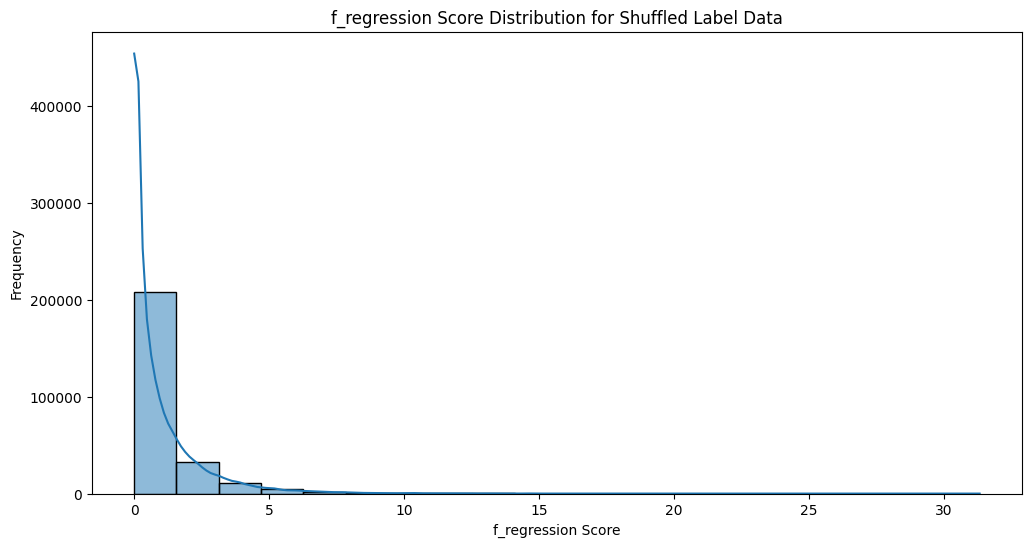

<Figure size 640x480 with 0 Axes>

In [74]:
method = f_regression_select
method_string = 'f_regression'
method_kwargs = {}
all_scores = get_shuffled_scores(shuffled_label_data, feature_data, method, method_kwargs, n_jobs=5)

# set plot size
plt.figure(figsize=(12, 6))
sns.histplot(all_scores, bins=20, kde=True)
plt.xlabel(f'{method_string} Score')
plt.ylabel('Frequency')
plt.title(f'{method_string} Score Distribution for Shuffled Label Data')
if show_figure: plt.show()
if save_figure: plt.savefig(f'{file_save_path}{exp_id}_{method_string}_shuffled_label_data.png')

In [72]:
# take the top 5% of scores as the threshold for feature selection
# remove nan first
all_scores = [score for score in all_scores if not np.isnan(score)]
threshold = np.percentile(all_scores, 95)
threshold

3.7952337708838777

In [ ]:
selected, scores = method(feature_data, label_data, feature_size, **method_kwargs)
df = build_dataframe(selected, scores, feature_data)

In [ ]:
# select features with scores above the threshold
df_above_threshold = df[df['Scores'] > threshold]
df_above_threshold
# save f_df_above_threshold to pkl file 
if save_data: df_above_threshold.to_pickle(f'{file_save_path}{exp_id}_{method_string}_above_threshold.pkl')

In [ ]:
df_above_threshold.shape

### Pearson Correlation

In [ ]:
method = pearson_corr_select
method_string = 'pearson_correlation'
method_kwargs = {'return_all': False}

all_scores = get_shuffled_scores(shuffled_label_data, feature_data, method, method_kwargs)


all_scores = [score for score in all_scores if not np.isnan(score)]
upper_threshold = np.percentile(all_scores, 97.5)
lower_threshold = np.percentile(all_scores, 2.5)
print(upper_threshold, lower_threshold)


# set plot size
plt.figure(figsize=(12, 6))
sns.histplot(all_scores, bins=20, kde=True)
plt.xlabel(f'{method_string} Score')
plt.ylabel('Frequency')
plt.title(f'{method_string} Score Distribution for Shuffled Label Data')
if show_figure: plt.show()
if save_figure: plt.savefig(f'{file_save_path}{exp_id}_{method_string}_shuffled_label_data.png')

In [ ]:
selected, scores = method(feature_data, label_data, feature_size, **method_kwargs)
df = build_dataframe(selected, scores, feature_data)

In [ ]:
# select features with scores above the threshold
# filter nan values
df = df.dropna()
df_above_threshold = df[df['Scores'] > upper_threshold]
df_below_threshold = df[df['Scores'] < lower_threshold]
# join the two dataframes
df_above_threshold = pd.concat([df_above_threshold, df_below_threshold])

# save f_df_above_threshold to pkl file 
if save_data: df_above_threshold.to_pickle(f'{file_save_path}{exp_id}_{method_string}_above_threshold.pkl')

In [ ]:
df_above_threshold.shape

### Mutual Information 

In [ ]:
# do it for all shuffled label data, join the scores and plot histogram distribution of scores 

import matplotlib.pyplot as plt
import seaborn as sns

method = mutual_information_select
method_string = 'mutual_information'
method_kwargs = {}

all_scores = get_shuffled_scores(shuffled_label_data, feature_data, method, method_kwargs, verbose=1, n_jobs=-1)

# set plot size
plt.figure(figsize=(12, 6))
sns.histplot(all_scores, bins=20, kde=True)
plt.xlabel(f'{method_string} Score')
plt.ylabel('Frequency')
plt.title(f'{method_string} Score Distribution for Shuffled Label Data')
if show_figure: plt.show()
if save_figure: plt.savefig(f'{file_save_path}{exp_id}_{method_string}_shuffled_label_data.png')
if save_data:
    # use pickle to save all_scores
    with open(f'{file_save_path}{exp_id}_{method_string}_all_shuffled_label_data.pkl', 'wb') as f:
        pickle.dump(all_scores, f)

### Relieff

In [ ]:
# do it for all shuffled label data, join the scores and plot histogram distribution of scores 

import pickle 

import matplotlib.pyplot as plt
import seaborn as sns

method = relieff_select
method_string = 'relieff'
method_kwargs = {}

all_scores = get_shuffled_scores(shuffled_label_data, feature_data, method, method_kwargs, verbose=1, n_jobs=-1)

# set plot size
plt.figure(figsize=(12, 6))
sns.histplot(all_scores, bins=20, kde=True)
plt.xlabel(f'{method_string} Score')
plt.ylabel('Frequency')
plt.title(f'{method_string} Score Distribution for Shuffled Label Data')
if show_figure: plt.show()
if save_figure: plt.savefig(f'{file_save_path}{exp_id}_{method_string}_shuffled_label_data.png')
if save_data: 
    # use pickle to save all_scores 
    with open(f'{file_save_path}{exp_id}_{method_string}_all_shuffled_label_data.pkl', 'wb') as f:
        pickle.dump(all_scores, f)

### Random Forest Embeddings 

In [ ]:
# do it for all shuffled label data, join the scores and plot histogram distribution of scores 

import matplotlib.pyplot as plt
import seaborn as sns

method = rf_select
method_string = 'random_forest'
method_kwargs = {}

all_scores = get_shuffled_scores(shuffled_label_data, feature_data, method, method_kwargs, n_jobs=-1)

# set plot size
plt.figure(figsize=(12, 6))
sns.histplot(all_scores, bins=20, kde=True)
plt.xlabel(f'{method_string} Score')
plt.ylabel('Frequency')
plt.title(f'{method_string} Score Distribution for Shuffled Label Data')
if show_figure: plt.show()
if save_figure: plt.savefig(f'{file_save_path}{exp_id}_{method_string}_shuffled_label_data.png')
if save_data: 
    # use pickle to save all_scores 
    with open(f'{file_save_path}{exp_id}_{method_string}_all_shuffled_label_data.pkl', 'wb') as f:
        pickle.dump(all_scores, f)

### Union of all methods

In [ ]:
# load from pkl file
methods = ['f_regression', 'pearson_correlation']
df_above_threshold_list = []
for method in methods:
    df_above_threshold = pd.read_pickle(f'{file_save_path}{exp_id}_{method}_above_threshold.pkl')
    df_above_threshold_list.append(df_above_threshold)

union_labels = []
for df in df_above_threshold_list:
    union_labels.extend(df.index.tolist())

# find out which labels are duplicated
from collections import Counter
label_counts = Counter(union_labels)
duplicated_labels = [label for label, count in label_counts.items() if count > 1]
print(duplicated_labels)
unique_labels = [label for label, count in label_counts.items() if count == 1]
print(unique_labels)

union_labels = list(set(union_labels))
len(union_labels)